In [1]:
import scanpy as sc
import os

In [2]:
import celltypist
from celltypist import models
import seaborn as sns
import pandas as pd 


In [3]:
def download_files(files: list[str])-> None:

    for filename in files:
        url = f"https://helicalpackage.blob.core.windows.net/helicalpackage/data/{filename}"

        # Check if the file already exists in the current directory
        if os.path.exists(filename):
            print(f"Files already exist. Skipping downloads.")
        else:
            response = requests.get(url)
            if response.status_code == 200:
                with open(filename, "wb") as file:
                    file.write(response.content)
                print(f"Downloaded {filename} successfully.")
            else:
                print(f"Failed to download {filename}.")

In [4]:
files = ["c_data.h5ad", "ms_default.h5ad"]
download_files(files)

Files already exist. Skipping downloads.
Files already exist. Skipping downloads.


In [5]:
adata = sc.read("c_data.h5ad") #training data
adata_query = sc.read("ms_default.h5ad") #query data 

In [6]:
adata.obs['celltype'].cat.categories

Index(['PVALB-expressing interneuron', 'SST-expressing interneuron',
       'SV2C-expressing interneuron', 'VIP-expressing interneuron',
       'astrocyte', 'cortical layer 2-3 excitatory neuron A',
       'cortical layer 2-3 excitatory neuron B',
       'cortical layer 4 excitatory neuron',
       'cortical layer 5-6 excitatory neuron', 'endothelial cell',
       'microglial cell', 'mixed excitatory neuron', 'mixed glial cell?',
       'oligodendrocyte A', 'oligodendrocyte C',
       'oligodendrocyte precursor cell', 'phagocyte', 'pyramidal neuron?'],
      dtype='object')

In [7]:
#I'm not doing any QC so that the genes and cells are the same as in the foundation models for our benchmark

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.normalize_total(adata_query, target_sum=1e4)
sc.pp.log1p(adata_query)

In [8]:
adata.obs['celltype'].cat.categories #these are brain cells

Index(['PVALB-expressing interneuron', 'SST-expressing interneuron',
       'SV2C-expressing interneuron', 'VIP-expressing interneuron',
       'astrocyte', 'cortical layer 2-3 excitatory neuron A',
       'cortical layer 2-3 excitatory neuron B',
       'cortical layer 4 excitatory neuron',
       'cortical layer 5-6 excitatory neuron', 'endothelial cell',
       'microglial cell', 'mixed excitatory neuron', 'mixed glial cell?',
       'oligodendrocyte A', 'oligodendrocyte C',
       'oligodendrocyte precursor cell', 'phagocyte', 'pyramidal neuron?'],
      dtype='object')

In [9]:
new_model = celltypist.train(adata, labels = 'celltype', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
🔬 Input data has 7844 cells and 3000 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2001 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [10]:
# Save the model
new_model.write('model_from_c_data.pkl')

In [11]:
new_model = models.Model.load('model_from_c_data.pkl')

In [12]:
predictions = celltypist.annotate(adata_query, model = 'model_from_c_data.pkl', majority_voting = True)

🔬 Input data has 7844 cells and 3000 genes
🔗 Matching reference genes in the model
🧬 2001 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [13]:
adata = predictions.to_adata()

In [14]:
sc.tl.umap(adata)

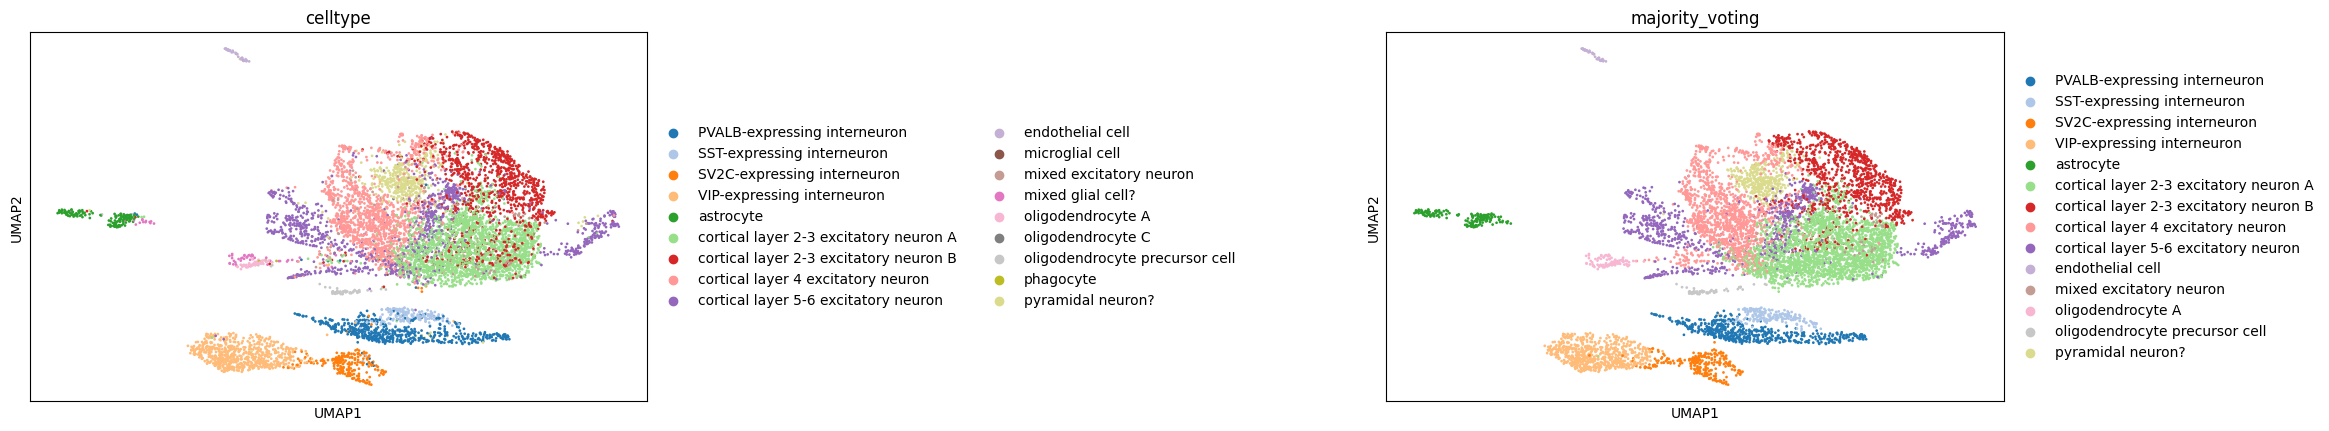

In [15]:

# Define the standard color palette
palette = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 20)  # Extending palette for more colors

# Combine all unique labels from 'celltype' and 'majority_voting'
all_labels = pd.Categorical(adata.obs[['celltype', 'majority_voting']].values.ravel()).categories

# Create a unified color dictionary
unified_color_dict = dict(zip(all_labels, palette[:len(all_labels)]))

# Function to match colors for any set of categories
def match_colors(base_dict, target_labels):
    return [base_dict[label] for label in target_labels if label in base_dict]

# Assign the unified colors to 'celltype' and 'majority_voting'
adata.uns['celltype_colors'] = match_colors(unified_color_dict, adata.obs['celltype'].cat.categories)
adata.uns['majority_voting_colors'] = match_colors(unified_color_dict, adata.obs['majority_voting'].cat.categories)

# Plot UMAP
sc.pl.umap(adata, color=['celltype', 'majority_voting'], wspace=1)

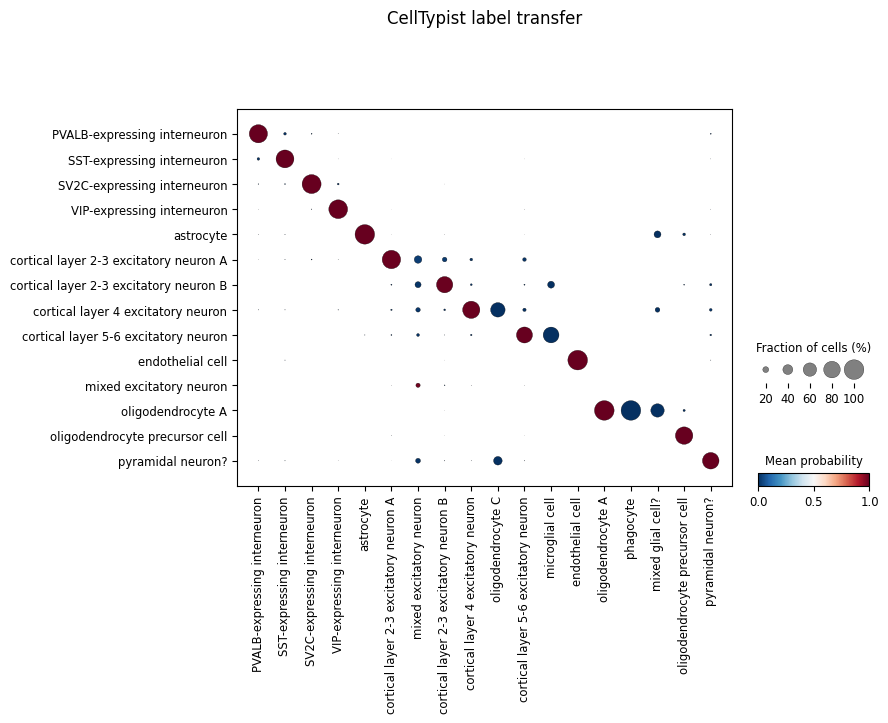

In [16]:
celltypist.dotplot(predictions, use_as_reference = 'celltype', use_as_prediction = 'majority_voting')

In [17]:
top_3_genes = new_model.extract_top_markers('PVALB-expressing interneuron', 3)
top_3_genes

array(['CNTNAP3', 'RGS5', 'ANK1'], dtype=object)

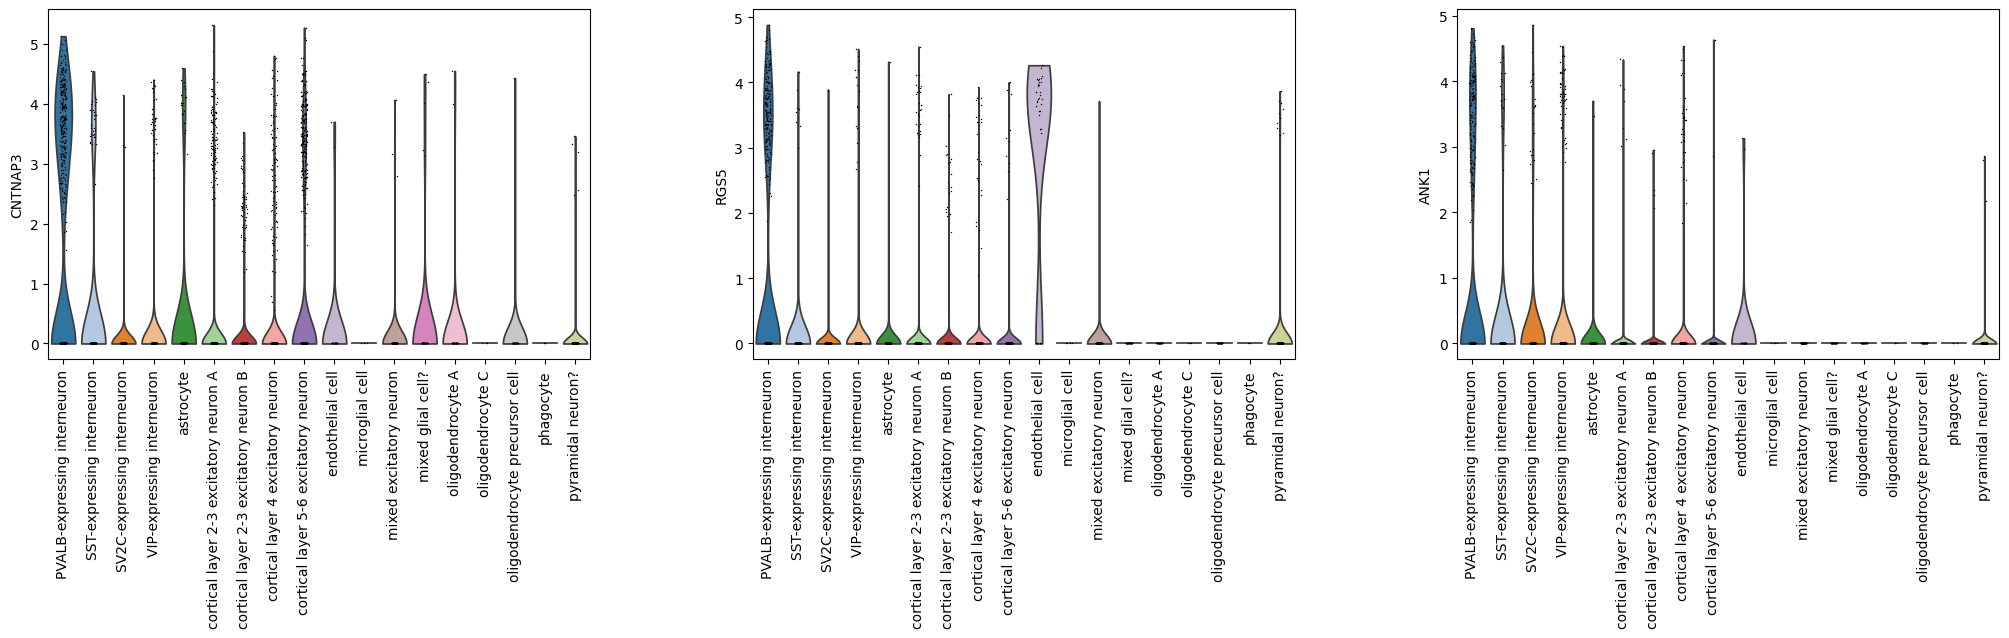

In [18]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata, top_3_genes, groupby = 'celltype', rotation = 90)

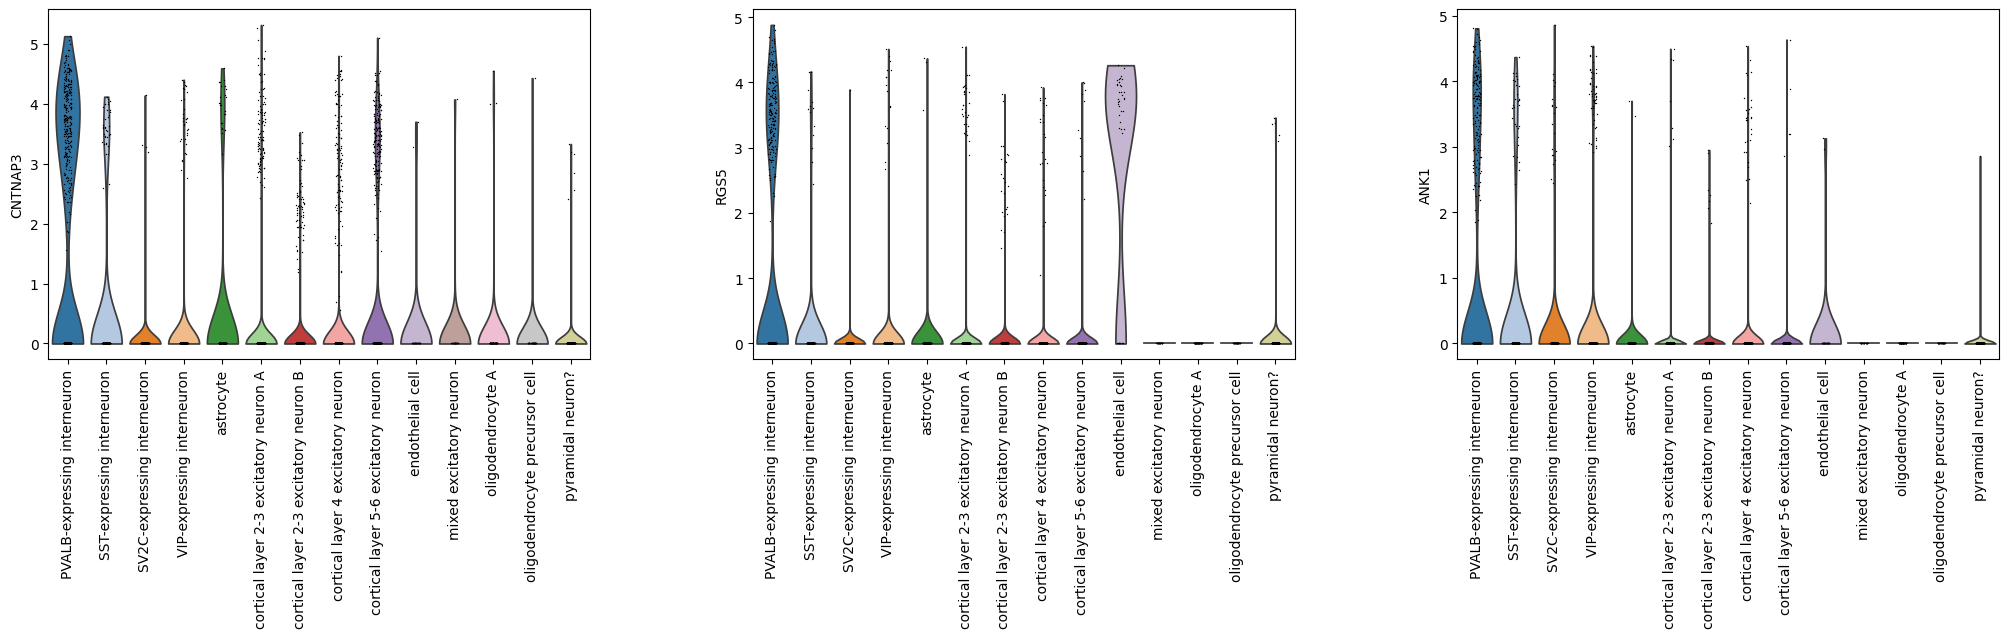

In [19]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_query, top_3_genes, groupby = 'majority_voting', rotation = 90)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = adata.obs['celltype']
pred_labels = adata.obs['majority_voting']

# Compute the accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute the precision
precision = precision_score(true_labels, pred_labels, average='weighted')

# Compute the recall
recall = recall_score(true_labels, pred_labels, average='weighted')

# Compute the F1 score
f1 = f1_score(true_labels, pred_labels, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.85
Precision: 0.84
Recall: 0.85
F1 Score: 0.84
